# XGBoost on SageMaker Serverless Inference

Got inspiration from this notebook:

https://github.com/aws/amazon-sagemaker-examples/blob/master/serverless-inference/Serverless-Inference-Walkthrough.ipynb


In [2]:
!pip install sagemaker botocore boto3 awscli --upgrade --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.23.49 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
import boto3

client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")

## 1. SageMaker Setup
To begin, we import the AWS SDK for Python (Boto3) and set up our environment, including an IAM role and an S3 bucket to store our data.

In [5]:
import boto3
import sagemaker
from sagemaker.estimator import Estimator

boto_session = boto3.session.Session()
region = boto_session.region_name
print(region)

sagemaker_session = sagemaker.Session()
base_job_prefix = "xgboost-example"
role = sagemaker.get_execution_role()
print(role)

default_bucket = sagemaker_session.default_bucket()
s3_prefix = base_job_prefix

training_instance_type = "ml.m5.xlarge"

eu-west-1
arn:aws:iam::077590795309:role/service-role/AmazonSageMaker-ExecutionRole-20191008T190827


## 2. Get the dataset and store on S3

In [6]:
# retrieve data
! curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/uci_abalone/train_csv/abalone_dataset1_train.csv > abalone_dataset1_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  131k  100  131k    0     0   277k      0 --:--:-- --:--:-- --:--:--  277k


Upload the Abalone dataset to the default S3 bucket.

In [7]:
# upload data to S3
!aws s3 cp abalone_dataset1_train.csv s3://{default_bucket}/xgboost-regression/train.csv

upload: ./abalone_dataset1_train.csv to s3://sagemaker-eu-west-1-077590795309/xgboost-regression/train.csv


## 3. Model Training

In [8]:
from sagemaker.inputs import TrainingInput

training_path = f"s3://{default_bucket}/xgboost-regression/train.csv"
train_input = TrainingInput(training_path, content_type="text/csv")

In [9]:
model_path = f"s3://{default_bucket}/{s3_prefix}/xgb_model"

# retrieve xgboost image
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=training_instance_type,
)

# Configure Training Estimator
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    output_path=model_path,
    sagemaker_session=sagemaker_session,
    role=role,
)

# Set Hyperparameters
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    silent=0,
)

Train the model on the Abalone dataset.

In [10]:
xgb_train.fit({"train": train_input})

2022-02-06 07:42:22 Starting - Starting the training job...
2022-02-06 07:42:46 Starting - Launching requested ML instancesProfilerReport-1644133342: InProgress
...
2022-02-06 07:43:15 Starting - Preparing the instances for training.........
2022-02-06 07:44:47 Downloading - Downloading input data
2022-02-06 07:44:47 Training - Downloading the training image...
2022-02-06 07:45:18 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[07:45:20] 2923x8 matrix with 23384 entries loaded from /opt/ml/input/data/train?form

## 4. Create a Sagemaker Model

In [13]:
# xgb_model.create_model() does not work, no sagemaker model is created and saved under Sagemaker > Inference > Models.
xgb_model._create_sagemaker_model(instance_type="ml.m5.xlarge", accelerator_type=None, tags=None)

In [18]:
sagemaker_model = xgb_model.name

## 5. Create Lambda handler

The lambda handler receives the request from API Gateway and forwards it to the sagemaker endpoint.

In [30]:
%%writefile lambda_handler.py
import json
import boto3
import os

runtime_client = boto3.client("runtime.sagemaker")
sagemaker_endpoint_name = os.environ["SAGEMAKER_ENDPOINT_NAME"]

def handler(event, context):
    
    body = json.loads(event["body"])
    data = body["data"]
    content_type = body["content_type"]
    
    print(f"making a prediction on the data: {data}")
    
    response = runtime_client.invoke_endpoint(
        EndpointName=sagemaker_endpoint_name,
        Body=data,
        ContentType=content_type,

    )
    prediction = response["Body"].read()

    
    print(f"prediction: {prediction}")
    return {
        'statusCode': 200,
        'body': prediction
    }


Overwriting lambda_handler.py


## 6. Create serverless.yml (www.serverless.com)
The serverless.yml file defines the services we use
 - API Gateway
 - Lambda 
 - Serverless Sagemaker Endpoint

In [31]:
# function to write variables to a textfile
# https://github.com/ipython/ipython/issues/6701#issuecomment-382640776
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [39]:
%%writetemplate serverless.yml
service: huggingface-on-serverless-sagemaker

provider:
  name: aws
  region: eu-west-1 
  runtime: python3.8
  iam:
    role:
      managedPolicies: arn:aws:iam::aws:policy/AdministratorAccess


functions:
  huggingface:
    handler: lambda_handler.handler
    timeout: 120
    memorySize: 128 
    events:
      - http:
          path: prediction
          method: post
    environment:
      SAGEMAKER_ENDPOINT_NAME: !GetAtt SageMakerEndpoint.EndpointName

resources:
  Resources:
    SageMakerEndpointConfig:
      Type: AWS::SageMaker::EndpointConfig
      Properties:
        ProductionVariants:
          - ModelName: {sagemaker_model}
            InitialVariantWeight: 1.0
            VariantName: SageMakerModel
            ServerlessConfig:
              MaxConcurrency: 50
              MemorySizeInMB: 4096

    SageMakerEndpoint:
      Type: AWS::SageMaker::Endpoint
      Properties:
        EndpointConfigName: !GetAtt SageMakerEndpointConfig.EndpointConfigName
        EndpointName: huggingface-serverless-sagemaker-endpoint


## 7. Deploy the application using AWS cloud shell.

```
git clone https://github.com/vincentclaes/xgboost-on-serverless-sagemaker.git

cd xgboost-on-serverless-sagemaker/

npm install serverless

/home/cloudshell-user/node_modules/serverless/bin/serverless.js deploy
```

# 8. Call Endpoint
## First call

In [33]:
%%time
!curl -d '{"data":".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0", "content_type":"text/csv"}' -H "Content-Type: application/json" -X POST  https://bpaxi49zq2.execute-api.eu-west-1.amazonaws.com/dev/prediction


4.566554546356201CPU times: user 10.6 ms, sys: 3.27 ms, total: 13.9 ms
Wall time: 481 ms


## Burst of 10 000 (Serverless Sagemaker max concurrency = 1)
The min latency is 57 ms, the max is 4651 ms, and the average is 139 ms.
0 errors

In [ ]:
%%time
from joblib import Parallel, delayed
import subprocess
import shlex
def process(i):
    print(".",)
    cmd = """curl -d '{"data":".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0", "content_type":"text/csv"}' -H "Content-Type: application/json" -X POST  https://bpaxi49zq2.execute-api.eu-west-1.amazonaws.com/dev/prediction"""
    subprocess.check_call(shlex.split(cmd))
    

results = Parallel(n_jobs=100)(delayed(process)(i) for i in range(10_000))

__We set the concurrency to 1, which probably caused these bad results.__


![Screen Shot 2022-02-03 at 21.49.04.png](attachment:Screen Shot 2022-02-03 at 21.49.04.png)
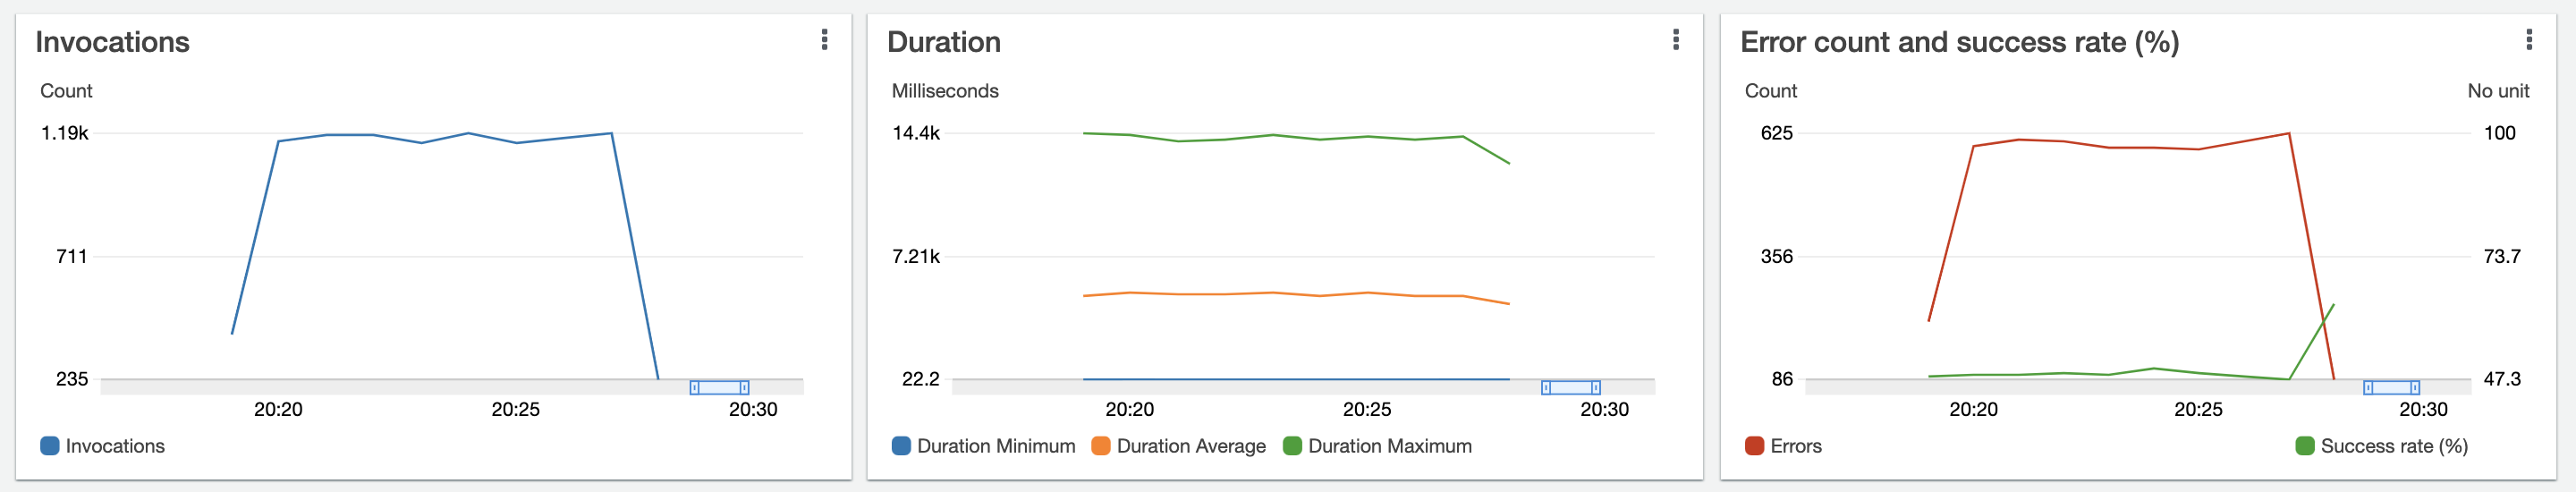

## Burst of 10 000 (Serverless Sagemaker max concurrency = 50)

- Default max concurrency of a lambda function is 1000. 
- serverless sagemaker max concurrency is 50

In [40]:
results = Parallel(n_jobs=100)(delayed(process)(i) for i in range(10_000))

# 4. Remove the stack

```
/home/cloudshell-user/node_modules/serverless/bin/serverless.js remove
```